## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import skew, zscore
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [2]:
pd.set_option('display.max_columns', 50)

## Load datasets

A quick look into the dataset and we could notice that the special character _"\N"_ is used instead of _NaN_ for missing values.

In [3]:
# X1: entry dataset (note: X2 is the testing dataset)
# use row `Unamed: 0` as the row index
X1 = pd.read_csv("datasets/X1.csv", na_values="\\N")
X1.head()

,Unnamed: 0,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings
0,2502,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937.0,0,2010,105.0,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934..."
1,6238,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,NaN,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722..."
2,1800,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345.0,0,1978,127.0,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415..."
3,2675,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851.0,0,1994,105.0,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693..."
4,3674,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549.0,0,1982,108.0,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391..."


In [4]:
#X1.loc[X1["title"] == "Clown"]

inputs dataset has dimension (3540, 14)

One first thing we can notice is that our dataset use a special character "\\N" for empty values. We should modify them to NaN.

In [4]:
# Y1: target dataset
Y1 = pd.read_csv("datasets/Y1.csv", header=None, names=["revenues"])
Y1.head()

,revenues
0,7.158530e+07
1,8.964834e+04
2,3.164907e+07
3,3.898197e+07
4,9.697023e+06


target dataset has dimension (3540, 1)

In [5]:
# X2: testing entry dataset
X2 = pd.read_csv("datasets/X2.csv", na_values="\\N")

In [6]:
print(f"X1 dataset contains {X1.shape[0]} observations and {X1.shape[1]} features")
print(f"X2 dataset (for prediction only) contains {X2.shape[0]} observations")

print(f"features: {list(X1.columns)}")
print(f"target: {list(Y1.columns)}")

X1 dataset contains 3540 observations and 14 features
X2 dataset (for prediction only) contains 1518 observations
features: ['Unnamed: 0', 'title', 'img_url', 'description', 'ratings', 'n_votes', 'is_adult', 'production_year', 'runtime', 'genres', 'release_year', 'studio', 'img_embeddings', 'text_embeddings']
target: ['revenues']


## Dataset description

inputs (X1):     
- `title`: title of the movie.    
- `ratings`: rating on IMDB.    
- `n_votes`: number of votes that are averaged for the given rating.    
- `is_adult`: is the movie destined for a mature audience (0 or 1).    
- `production_year`: the year the movie was produced.    
- `release_year`: the year the movie was released.    
- `runtime`: how long the movie lasts for (in minutes).    
- `genres`: a list of maximum 3 genres that fits the movie.   
- `studio`: the movie studio that produced the movie.        
- `img.url`: the url of the poster of the movie.    
- `img.embeddings`: vector of size 2048 representing the poster.    
- `description`: synopsis of the movie.    
- `text.embeddings`: vector of size 768 representing the synopsis.

There is also an `"Unnamed: 0"` column that seems to be an **id for the movie**. We can remove it.

target (Y1):     
- `revenue`: the amount in dollars the movie made in the USA.    

In [7]:
# drop unecessary column `Unnamed: 0`
X1.drop("Unnamed: 0", axis=1, inplace=True)

For feature engineering and the sake of simplicity, we're gonna concatenate the inputs `X1` with the target `Y1`

In [8]:
df = pd.concat([X1, Y1], axis = 1)
df.head()

,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings,revenues
0,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937.0,0,2010,105.0,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934...",7.158530e+07
1,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,NaN,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722...",8.964834e+04
2,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345.0,0,1978,127.0,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415...",3.164907e+07
3,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851.0,0,1994,105.0,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693...",3.898197e+07
4,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549.0,0,1982,108.0,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391...",9.697023e+06


## EDA

### Types of variables

Let's check the different types of variables

In [9]:
# types of variables
df.dtypes.value_counts()

object     7
float64    5
int64      2
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540 entries, 0 to 3539
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            3540 non-null   object 
 1   img_url          3540 non-null   object 
 2   description      3540 non-null   object 
 3   ratings          3540 non-null   float64
 4   n_votes          3540 non-null   float64
 5   is_adult         3540 non-null   int64  
 6   production_year  3540 non-null   int64  
 7   runtime          3276 non-null   float64
 8   genres           3536 non-null   object 
 9   release_year     3540 non-null   float64
 10  studio           3540 non-null   object 
 11  img_embeddings   3540 non-null   object 
 12  text_embeddings  3540 non-null   object 
 13  revenues         3540 non-null   float64
dtypes: float64(5), int64(2), object(7)
memory usage: 387.3+ KB


- `n_votes` and `release_year` are of type **float** but we could have thought they would be of type **int**.

In [12]:
df["n_votes"].unique()

array([9.2937e+04, 1.1000e+01, 1.3450e+03, ..., 2.2860e+03, 4.1810e+03,
       2.7379e+04])

In [13]:
df["release_year"].unique()

array([2010., 2014., 1978., 1994., 1982., 2000., 1990., 2002., 1997.,
       2009., 2001., 2003., 2007., 1992., 1998., 1995., 2008., 1983.,
       2015., 1991., 2016., 2006., 1973., 2004., 2011., 1999., 1986.,
       2005., 1996., 2013., 1993., 1989., 2012., 1987., 1988., 2017.,
       1980., 1985., 1981., 1979., 1984., 1977., 2018., 1946., 1975.,
       1966., 1971., 1974., 1941., 1957., 1970., 1976., 1972., 1959.])

For sure we could convert `release_year` to type **int**.

### Duplicated observations

Let's check if we have any duplicate observations (we saw before that there could be duplicated movies with different `movie_id`)

In [14]:
df[df.duplicated(subset=df.columns.difference(["revenues"]))].count()

title              432
img_url            432
description        432
ratings            432
n_votes            432
is_adult           432
production_year    432
runtime            395
genres             431
release_year       432
studio             432
img_embeddings     432
text_embeddings    432
revenues           432
dtype: int64

We have 432 duplicated observations

### Missing values

Let's see if there is any empty values

In [15]:
df.isna().sum()

title                0
img_url              0
description          0
ratings              0
n_votes              0
is_adult             0
production_year      0
runtime            264
genres               4
release_year         0
studio               0
img_embeddings       0
text_embeddings      0
revenues             0
dtype: int64

In [16]:
# number of missing values
X2.isna().sum()

Unnamed: 0           0
title                0
img_url              0
description          0
ratings              0
n_votes              0
is_adult             0
production_year      0
runtime            106
genres               4
release_year         0
studio               0
img_embeddings       0
text_embeddings      0
dtype: int64

Dataset for modelling :
There are 264 missing values for `runtime` feature and 4 missing values for `genres` feature.

Dataset for prediction :
There are 106 missing values for `runtime` feature and 4 missing values for `genres` feature.

In [17]:
# percentage of missing values
((df.isna().sum() / df.shape[0]) * 100).round(decimals = 2)

title              0.00
img_url            0.00
description        0.00
ratings            0.00
n_votes            0.00
is_adult           0.00
production_year    0.00
runtime            7.46
genres             0.11
release_year       0.00
studio             0.00
img_embeddings     0.00
text_embeddings    0.00
revenues           0.00
dtype: float64

In [18]:
((X2.isna().sum() / X2.shape[0]) * 100).round(decimals = 2)

Unnamed: 0         0.00
title              0.00
img_url            0.00
description        0.00
ratings            0.00
n_votes            0.00
is_adult           0.00
production_year    0.00
runtime            6.98
genres             0.26
release_year       0.00
studio             0.00
img_embeddings     0.00
text_embeddings    0.00
dtype: float64

<AxesSubplot:>

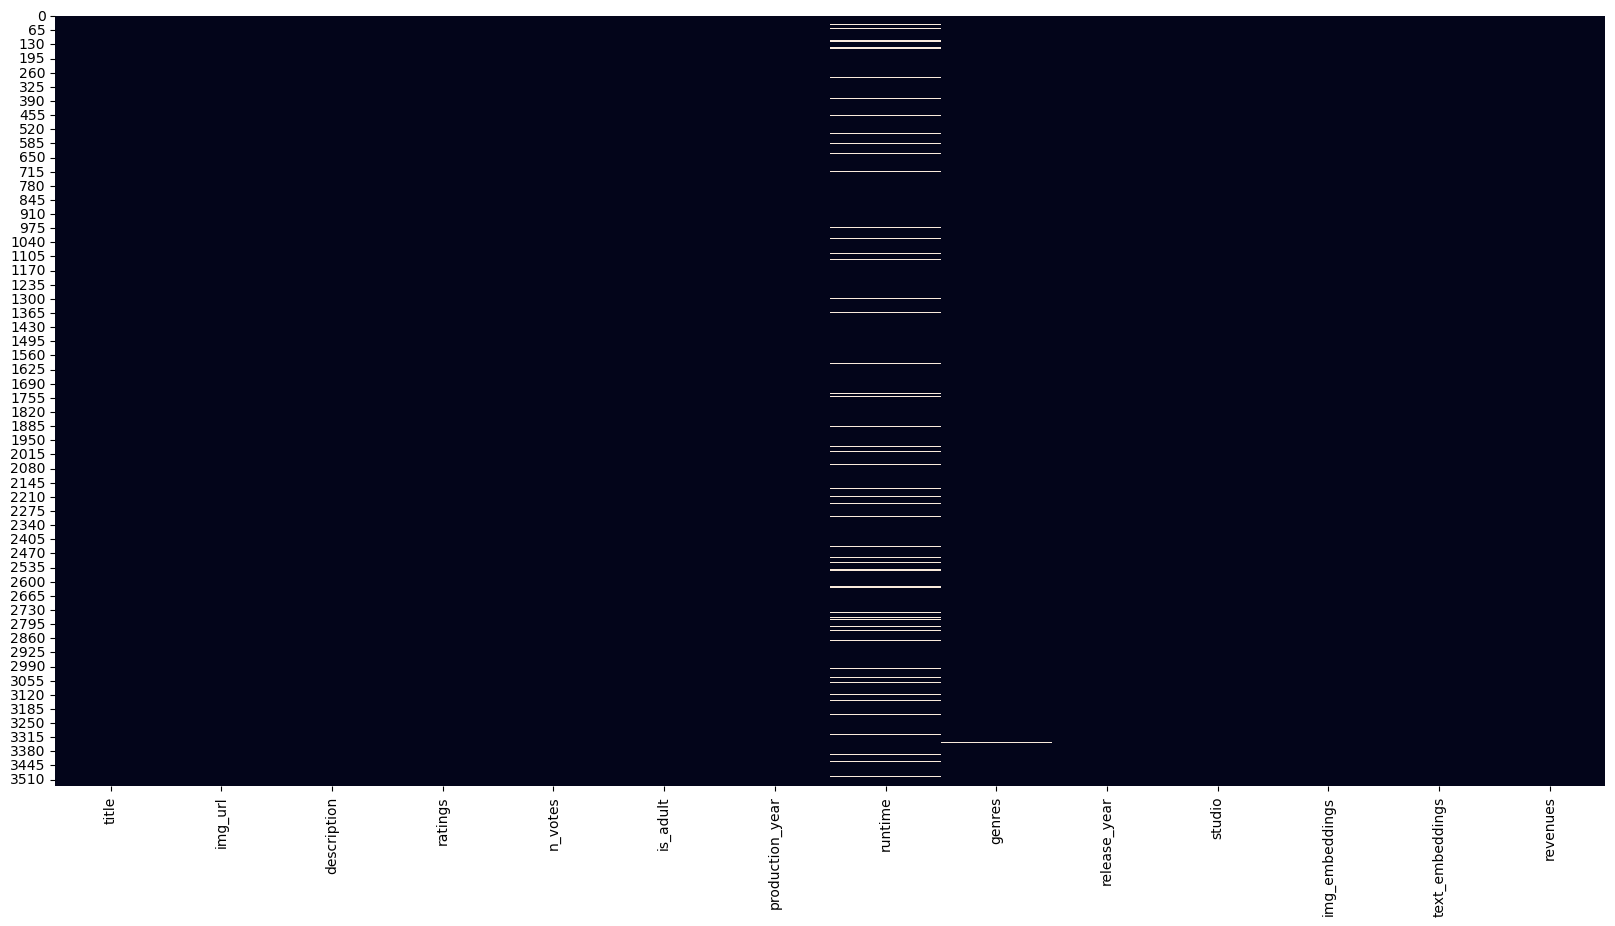

In [19]:
plt.figure(figsize = (20, 10))
sns.heatmap(df.isna(), cbar = False)

In [20]:
df.loc[df.isna().any(axis=1)]

,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings,revenues
1,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,NaN,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722...",8.964834e+04
9,Change of Plans,https://m.media-amazon.com/images/M/MV5BMDFhZj...,Change of Plans: Directed by Randy Zisk. With ...,8.2,12.0,0,1992,NaN,"Crime,Drama",2010.0,IFC,"[0.20134872, 3.3128614, 1.3217659, 0.05505188,...","[-0.7538657, 0.43110898, 0.9997868, -0.9895797...",6.305640e+04
38,Clown,https://m.media-amazon.com/images/M/MV5BMjBiOD...,Clown: Directed by Steve Lyons. With Jeff Benn...,8.6,5.0,0,2001,NaN,"Animation,Comedy,Family",2016.0,W/Dim.,"[0.14516667, 0.06064418, 0.15632975, 0.1824489...","[-0.65403396, 0.3780646, 0.999505, -0.97987425...",6.747525e+04
41,Rugrats in Paris: The Movie,https://m.media-amazon.com/images/M/MV5BYzBiNW...,Rugrats in Paris: The Movie: With Cheryl Chase...,6.4,74.0,0,2000,NaN,"Action,Adventure,Comedy",2000.0,Par.,"[0.47641614, 0.82069486, 0.22295909, 0.1736825...","[-0.68661237, 0.37858504, 0.9997692, -0.978913...",1.308007e+08
57,In Bloom,https://m.media-amazon.com/images/M/MV5BYWNmZj...,In Bloom: Directed by Marc Buckland. With Neal...,8.4,16.0,0,2004,NaN,"Drama,Mystery",2014.0,BWP,"[0.30072853, 3.2013667, 0.42100322, 0.10732664...","[-0.787354, 0.46719107, 0.9998723, -0.9922189,...",6.976546e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3492,The Channel,https://m.media-amazon.com/images/M/MV5BNzAwOT...,The Channel: Directed by Jorge Montesi. With S...,7.3,26.0,0,1999,NaN,"Adventure,Drama,Mystery",2016.0,Indic.,"[0.3205554, 0.3742889, 0.11509394, 0.9490364, ...","[-0.60545, 0.31592008, 0.9992462, -0.97367644,...",2.247131e+04
3495,Darshan,https://m.media-amazon.com/images/M/MV5BN2Y2Zj...,Darshan: Directed by Chimanlal Luhar. With Pre...,7.0,8.0,0,1941,NaN,NaN,2006.0,IFC,"[0.056906767, 0.1291496, 0.07299683, 0.0496285...","[-0.7949531, 0.46442604, 0.99984866, -0.991559...",9.642768e+04
3496,Dog Days of Summer,https://m.media-amazon.com/images/M/MV5BMjExNj...,"Dog Days of Summer: Directed by Chris Buck, Cl...",6.2,6.0,0,1993,NaN,"Animation,Comedy,Family",2008.0,MTop,"[0.21031177, 0.622036, 0.10827673, 0.14782186,...","[-0.672096, 0.35698575, 0.9996098, -0.98000515...",7.360684e+03
3504,Area 51,https://m.media-amazon.com/images/M/MV5BMjE4Nz...,"Area 51: With Tom Kane, Joerg Arnu, T.D. Barne...",5.7,6.0,0,2004,NaN,Documentary,2015.0,PARAIN,"[0.68146044, 1.8886466, 2.4086003, 0.9816384, ...","[-0.6459968, 0.31116134, 0.99957985, -0.981476...",9.386019e+03


Let's check the rows containing missing values

**Rule of thumb**: _if values are missing at random and percentage of observations with these missing values are less than $5\%$. We can drop them without risking of creating bias in our dataset._

We have $0.3\%$ of entries with missing values for `genres` features. These are random missing values (no reason for these to be missing, probably forgotten) so we can definitelty drop these entries without risk of creating bias in our dataset.
However, for the `runtime` feature, we have ~ $7\%$ of missing values. That's a little bit much for removing all these entries even though they also seem to be random missing values.

We could try to impute by mean or something else.

0    90.0
Name: runtime, dtype: float64


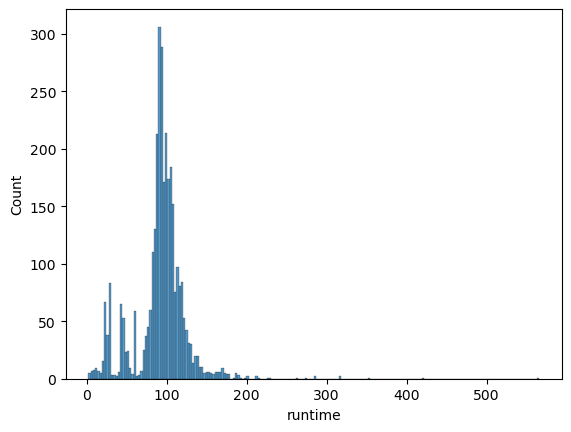

In [21]:
sns.histplot(df["runtime"])

print(df["runtime"].mode())

If data is missing randomly but the rows with these missing values are more than $5\%$ of the dataset, we can use **mean** (in case feature is normally distributed) or **median** (otherwise) imputation. We can also consider **mode** imputation.

However, keep in mind it affects data distribution (in particular the variance is reduced).

In [22]:
print("runtime mean: {}".format(df["runtime"].mean()))
print("runtime median: {}".format(df["runtime"].median()))
print("runtime mode: {}".format(df["runtime"].mode()))

runtime mean: 92.29334554334554
runtime median: 95.0
runtime mode: 0    90.0
Name: runtime, dtype: float64


In [23]:
df.dropna(subset=["genres"], axis=0, inplace=True)
df["runtime"].fillna(df["runtime"].mean(), inplace=True)

In [24]:
df["release_year"] = df["release_year"].astype(int)

<AxesSubplot:>

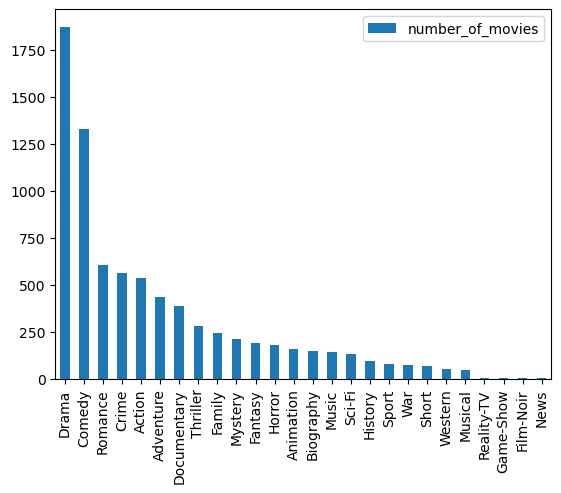

In [18]:
df.dropna(subset=["genres"], axis=0, inplace=True)

genres_lists = df["genres"].str.split(",").tolist()

genres_dict = {}

# retrieve each genre
for sublist in genres_lists:
	for genre in sublist:
		if genre in genres_dict:
			genres_dict[genre] += 1
		else:
			genres_dict[genre] = 1

genres_df = pd.DataFrame.from_dict(genres_dict, columns=["number_of_movies"], orient="index")
genres_df.sort_values(by="number_of_movies", ascending=False, inplace=True)
genres_df.plot.bar()

Text(0, 0.5, 'Revenues')

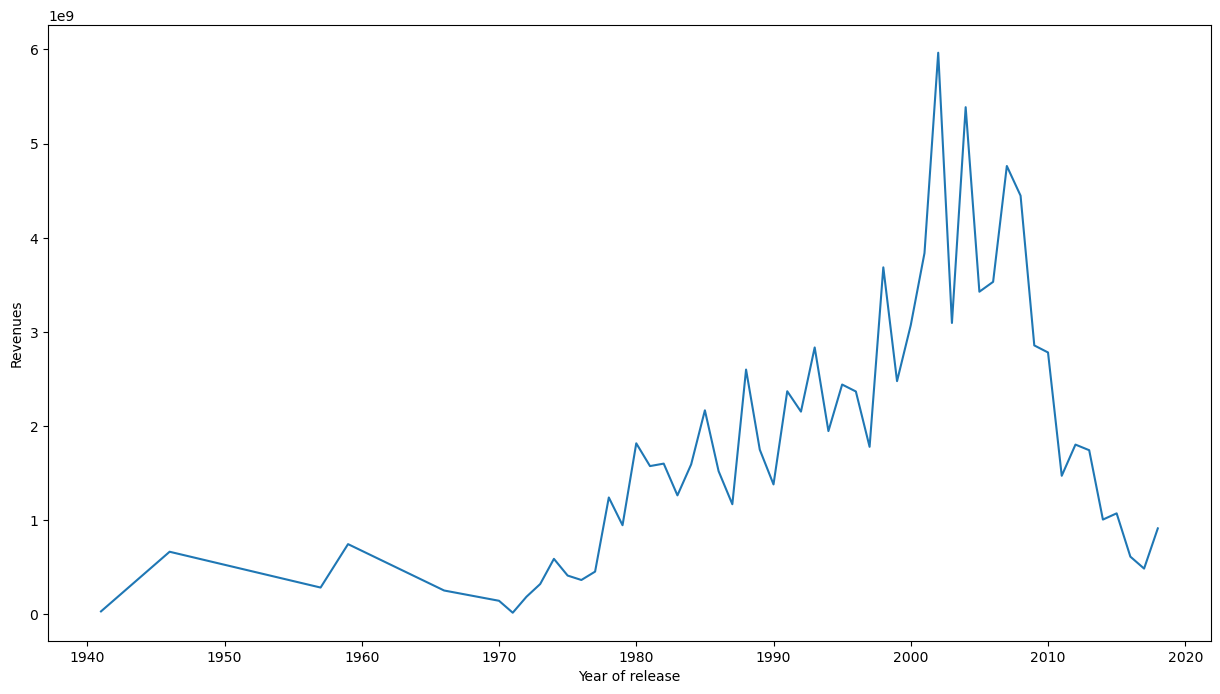

In [25]:
revenues_by_year = df[["release_year", "revenues"]].groupby("release_year")["revenues"].sum()

revenues_by_year.plot(figsize=(15, 8))
plt.xlabel("Year of release")
plt.ylabel("Revenues")

### Analysis of features

In [26]:
def find_outliers(column):
	z_score = np.abs(zscore(column))
	outliers = np.where(z_score > 3, True, False)
	return pd.Series(outliers, index=column.index)

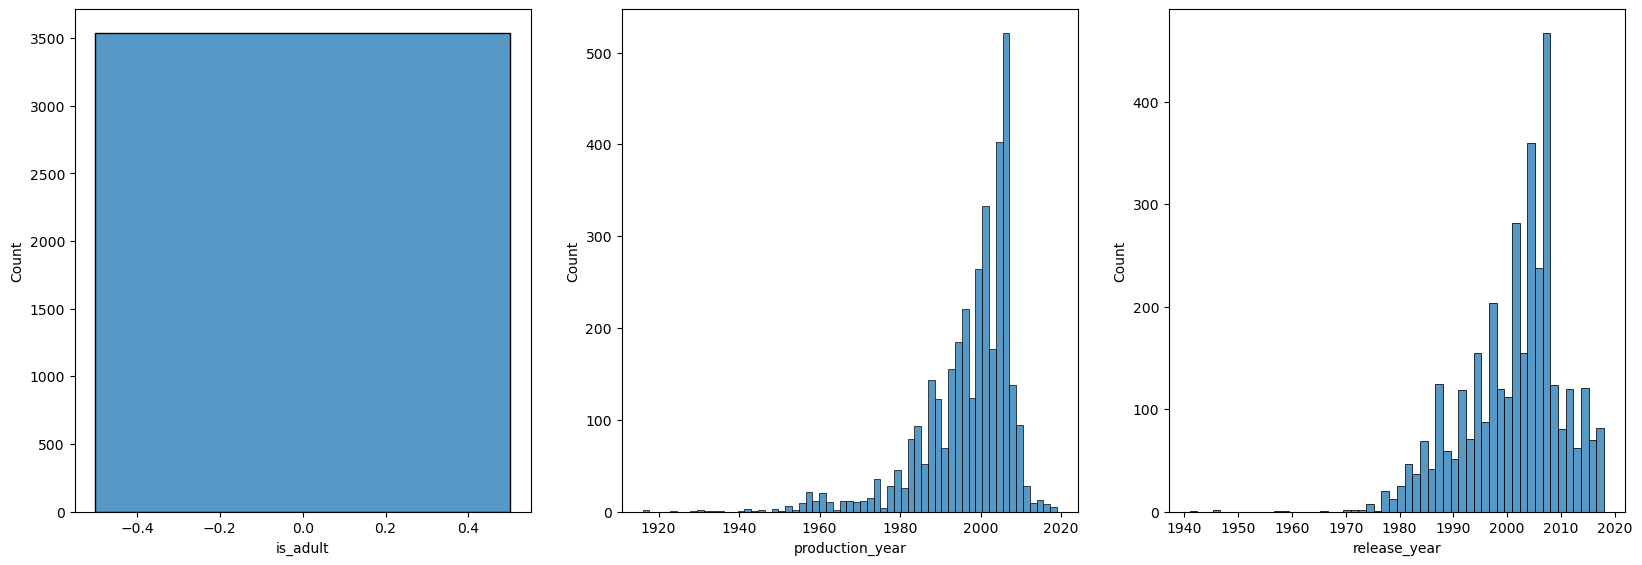

In [27]:
plt.subplots(figsize=(20,30))

i = 1

for col in df.select_dtypes("int"):
    plt.subplot(4,3,i)
    sns.histplot(df[col])
    i += 1

There seems to be only _non-adult_ movies (to confirm later).

Movies were mainly produced between **1990** and **2010**. We have a slightly left skewed distribution but it is more or less **normally distributed**.

In [28]:
df["is_adult"].value_counts()

0    3536
Name: is_adult, dtype: int64

/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='production_year'>

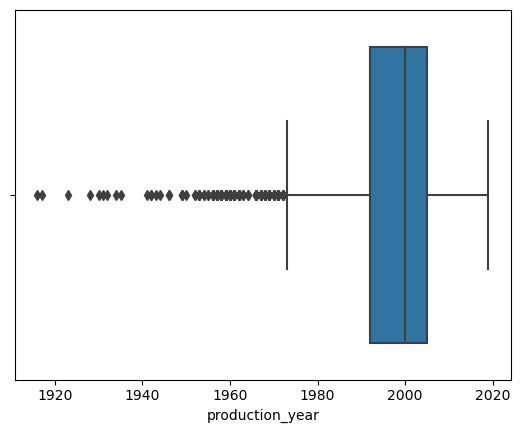

In [29]:
sns.boxplot(df["production_year"])

Indeed, we **do not have any movies** for a _mature audience_. 
Therefore, we could drop this column.

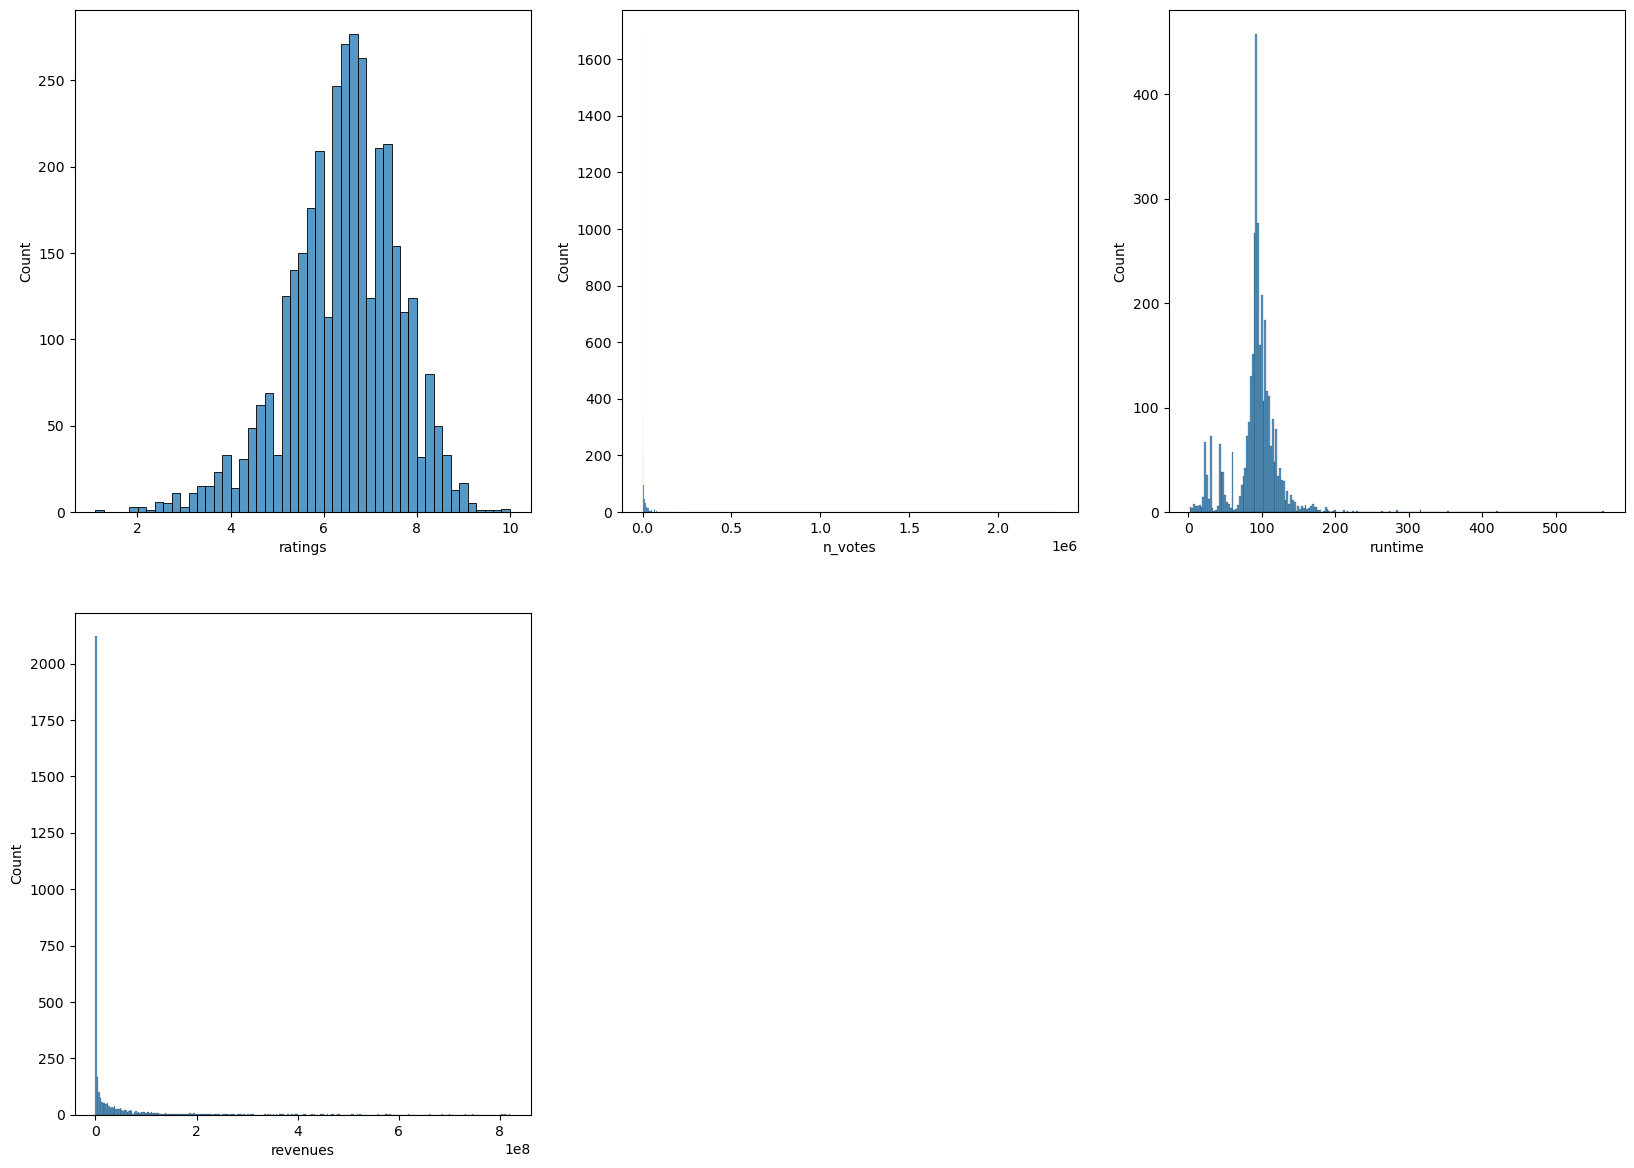

In [30]:
plt.subplots(figsize=(20,30))

i = 1

for col in df.select_dtypes("float"):
    plt.subplot(4, 3, i)
    sns.histplot(df[col])
    i += 1

/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0       False
1       False
2       False
3       False
4       False
        ...  
3535    False
3536    False
3537    False
3538    False
3539    False
Length: 3536, dtype: bool

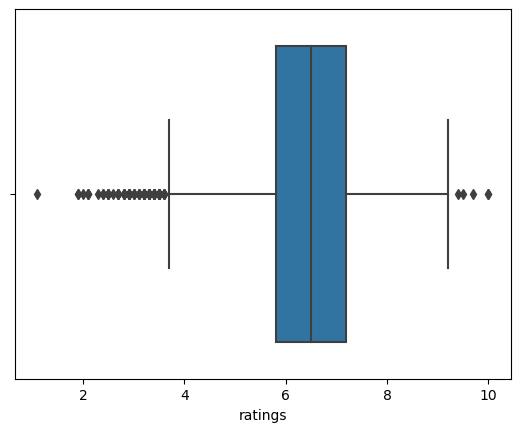

In [31]:
sns.boxplot(df["ratings"])
find_outliers(df["ratings"])

/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='runtime'>

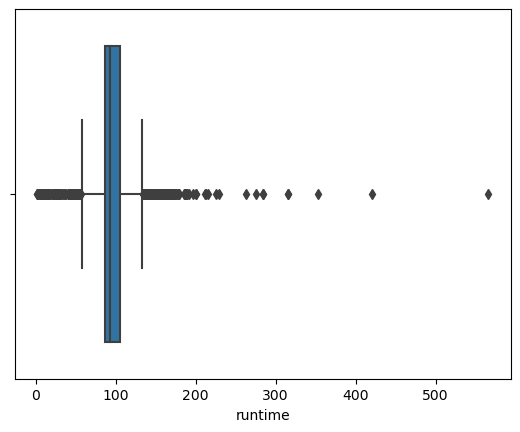

In [32]:
sns.boxplot(df["runtime"])

- `ratings`, `runtime` and `release_year` features are more or less **normally distributed**.

- `ratings` have a mean around **6.5**.

- Most movies were released between **2005** and **2010**. 

- `n_votes` feature and `revenues` target are **heavily right skewed**. We will have to manage that.

### Skewness and outliers analysis

In [33]:
df.skew().sort_values(ascending=False)

/var/folders/zn/_2h7w2j547357vpm3_5pxrsr0000gn/T/ipykernel_40712/4024944668.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.skew().sort_values(ascending=False)


n_votes            10.773892
revenues            5.079278
runtime             1.531993
is_adult            0.000000
ratings            -0.517096
release_year       -0.801694
production_year    -1.887726
dtype: float64

<AxesSubplot:ylabel='n_votes'>

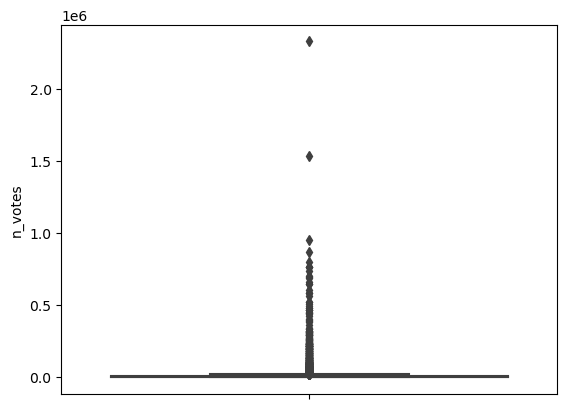

In [34]:
sns.boxplot(y = df["n_votes"])

<AxesSubplot:ylabel='revenues'>

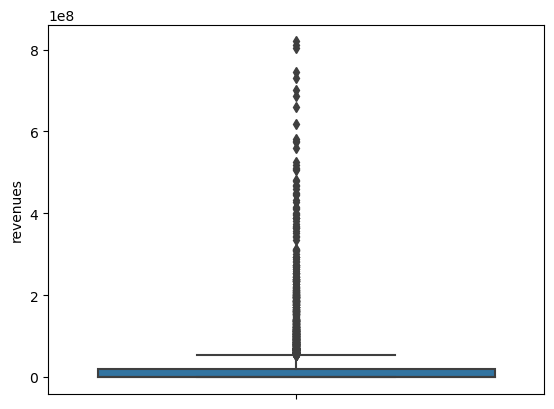

In [35]:
sns.boxplot(y = df["revenues"])

<AxesSubplot:ylabel='n_votes'>

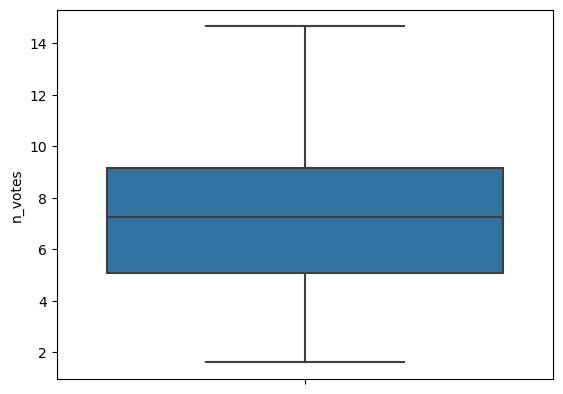

In [36]:
sns.boxplot(y = np.log(df["n_votes"]))

<AxesSubplot:xlabel='n_votes', ylabel='Count'>

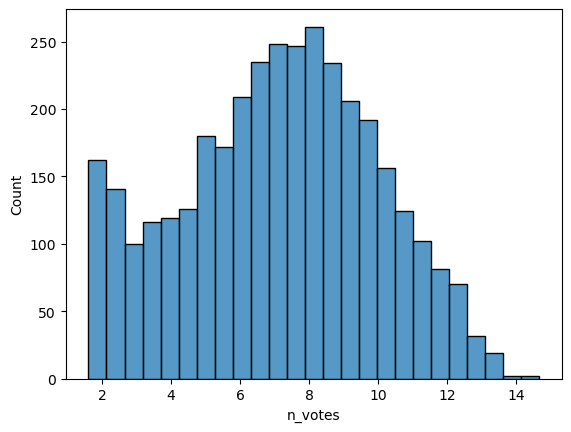

In [37]:
sns.histplot(np.log(df["n_votes"]))

<AxesSubplot:ylabel='revenues'>

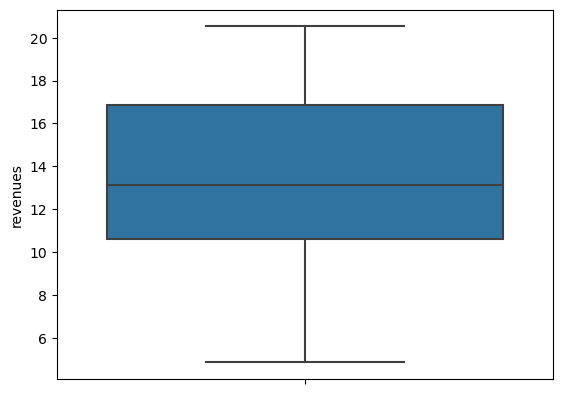

In [38]:
sns.boxplot(y = np.log(df["revenues"]))

<AxesSubplot:xlabel='revenues', ylabel='Count'>

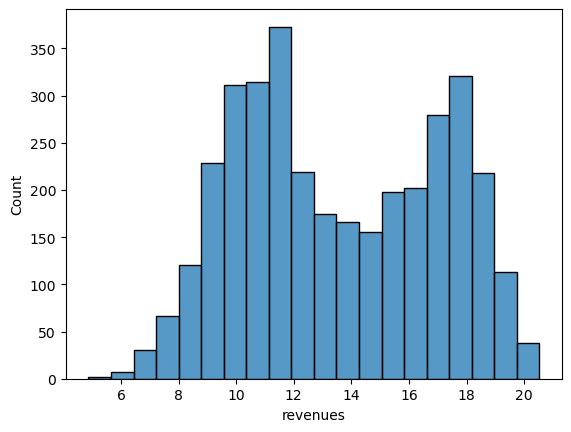

In [39]:
sns.histplot(np.log(df["revenues"]))

For these two variables, 50% of the data are concentrated on a small range of values. But they contain a lot of outliers until pretty high values (that's why distribution is heavily right skewed).

We see that we can perform a **log** transform on the 2 features to fix the skewness.

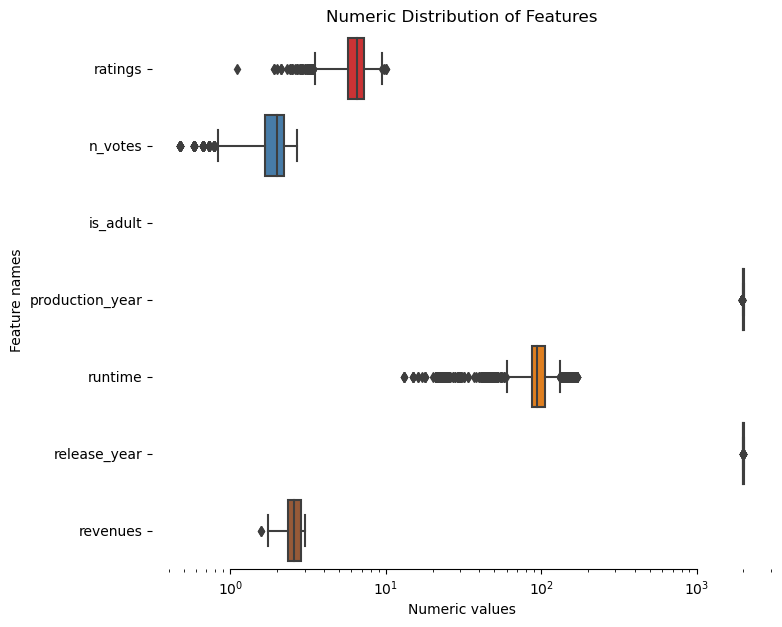

In [83]:
log_df = df 
log_df["n_votes"] = np.log(log_df["n_votes"])
log_df["revenues"] = np.log(log_df["revenues"])

fig, ax = plt.subplots(figsize=(8, 7))

ax.set_xscale("log")
ax = sns.boxplot(data=log_df.select_dtypes(np.number), orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

<AxesSubplot:xlabel='runtime', ylabel='Count'>

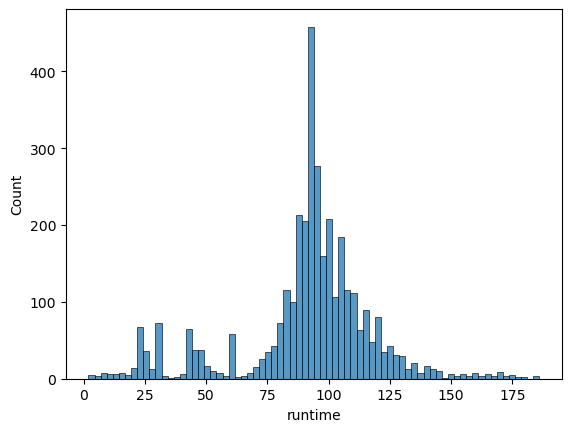

In [58]:
z_score = np.abs(zscore(df["runtime"]))

df = df[(z_score < 3)]
sns.histplot(df["runtime"])

<AxesSubplot:xlabel='production_year', ylabel='Count'>

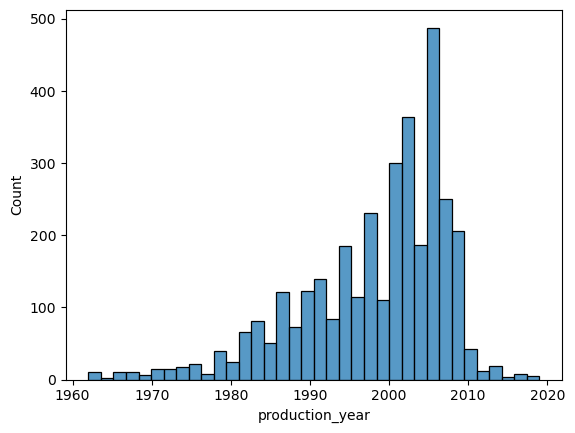

In [29]:
z_score = np.abs(zscore(df["production_year"]))

df = df[(z_score < 3)]
sns.histplot(df["production_year"])

<AxesSubplot:xlabel='release_year', ylabel='Count'>

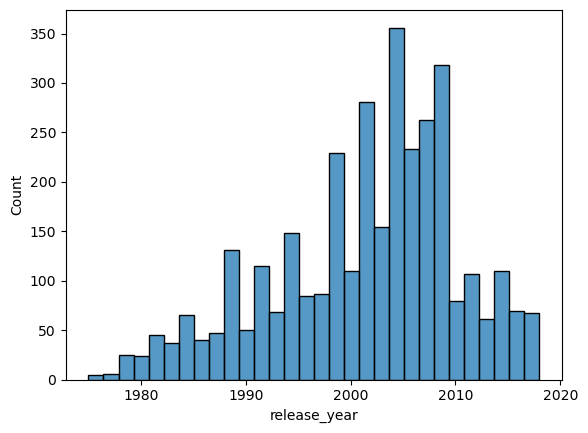

In [73]:
z_score = np.abs(zscore(df["release_year"]))
df = df[(z_score < 3)]

sns.histplot(df["release_year"])

In [46]:
#df[(np.abs() < 3).all(axis = 1)]
#df[["runtime"]]
df[np.abs(zscore(df[["production_year", "release_year"]]) < 3).all(axis=1)]

,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings,revenues
0,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937.0,0,2010,105.0,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934...",7.158530e+07
1,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,NaN,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722...",8.964834e+04
2,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345.0,0,1978,127.0,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415...",3.164907e+07
3,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851.0,0,1994,105.0,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693...",3.898197e+07
4,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549.0,0,1982,108.0,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391...",9.697023e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3534,Gardens of the Night,https://m.media-amazon.com/images/M/MV5BMTIzMz...,Gardens of the Night: Directed by Damian Harri...,6.9,4181.0,0,2008,110.0,Drama,2008.0,CityL,"[0.37097943, 3.1644535, 0.24232517, 0.16169561...","[-0.5455457, 0.3419857, 0.999181, -0.96788496,...",1.563752e+04
3535,Stiff Upper Lips,https://m.media-amazon.com/images/M/MV5BNGRiMz...,Stiff Upper Lips: Directed by Gary Sinyor. Wit...,6.3,973.0,0,1997,94.0,Comedy,1999.0,Cow.,"[0.19991912, 1.3718543, 1.1531808, 0.052152418...","[-0.55224955, 0.26953417, 0.99950045, -0.98031...",1.280834e+05
3537,Girlfight,https://m.media-amazon.com/images/M/MV5BMTMzMz...,Girlfight: Directed by Lawrence Trilling. With...,7.6,34.0,0,2001,44.0,"Drama,Romance",2000.0,SGem,"[0.15014637, 2.0139444, 1.0844889, 0.17270318,...","[-0.61463475, 0.4013893, 0.99981415, -0.985390...",2.677043e+06
3538,This Film Is Not Yet Rated,https://m.media-amazon.com/images/M/MV5BMTk0ND...,This Film Is Not Yet Rated: Directed by Kirby ...,7.5,27379.0,0,2006,98.0,Documentary,2006.0,IFC,"[0.25391683, 3.8994913, 0.23327282, 0.17322594...","[-0.74685824, 0.43955636, 0.99979496, -0.98784...",4.480911e+05


In [89]:
# Find skewed numerical features
skew_features = df.select_dtypes(np.number).apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 0 numerical features with Skew > 0.5 :


revenues          -0.285123
ratings           -0.512007
release_year      -0.568741
runtime           -0.803755
production_year   -1.053165
n_votes           -1.055609
is_adult                NaN
dtype: float64

/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='production_year'>

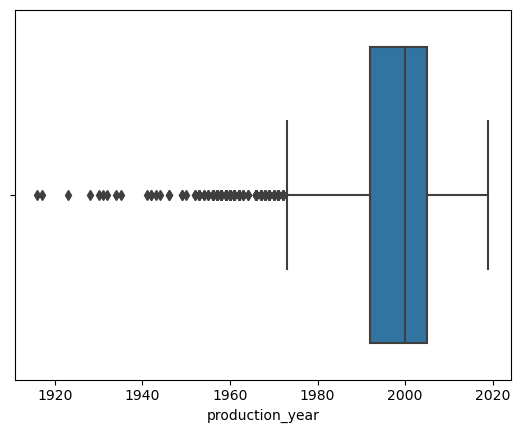

In [60]:
#sns.boxplot(boxcox1p(df["runtime"], boxcox_normmax(df["runtime"] + 1)))

In [ ]:
df.describe()

Let's analyze the range of the different numericals features

In [ ]:
(df.select_dtypes(include=["int64", "float64"]).max() - df.select_dtypes(include=["int64", "float64"]).min()).round(decimals=3)

Finally we count the number of unique values for the 2 categorical features `genres` and `studio`.

In [ ]:
df["genres"].describe()

`genre` feature contains list of maximum 3 most representative genres for each movies so there are many differents list of genres which does not mean there a as much different genres. We should preprocess them before then count how many different genres there are. 
However, we can expect there shouldn't be too many differents.

In [ ]:
df["studio"].describe()

We see there are $498$ different studios (**high-cardinality** problem), therefore, it will result in a lof of features if we One-Hot encode them. As a consequence, we would explose the dimensionnality of the datas and there would be more risk to overfit (curse of dimensionnality). Better to Label encode ? Let's check first the distribution of this feature

In [30]:
from collections import Counter

Counter(df["studio"]).most_common()

[('WB', 178),
 ('Uni.', 145),
 ('BV', 142),
 ('Par.', 126),
 ('Fox', 112),
 ('Mira.', 111),
 ('Sony', 99),
 ('IFC', 89),
 ('MGM', 85),
 ('Magn.', 64),
 ('NL', 59),
 ('SPC', 57),
 ('Strand', 52),
 ('Col.', 48),
 ('Lions', 46),
 ('FoxS', 44),
 ('Reg.', 40),
 ('Indic.', 39),
 ('FRun', 39),
 ('Eros', 37),
 ('Think', 35),
 ('Orion', 34),
 ('Gold.', 33),
 ('TriS', 32),
 ('Palm', 26),
 ('FL', 25),
 ('Gram.', 24),
 ('IDP', 23),
 ('First', 22),
 ('Focus', 22),
 ('Art.', 21),
 ('Truly', 20),
 ('NYer', 20),
 ('SGem', 20),
 ('Zeit.', 20),
 ('RAtt.', 20),
 ('AL', 20),
 ('Kino', 19),
 ('LGF', 18),
 ('MBox', 18),
 ('CLS', 17),
 ('7Art', 17),
 ('Free', 16),
 ('ParC', 15),
 ('FM', 15),
 ('UA', 15),
 ('Bal.', 14),
 ('Shad.', 14),
 ('Can.', 14),
 ('Trim.', 14),
 ('USA', 14),
 ('Vita.', 14),
 ('ICir', 13),
 ('Wein.', 13),
 ('UTV', 13),
 ('Mont.', 12),
 ('Scre.', 12),
 ('DW', 12),
 ('Castle', 12),
 ('WIP', 12),
 ('Anch.', 12),
 ('KL', 12),
 ('Oct.', 12),
 ('Abr.', 12),
 ('Slow', 11),
 ('SonR', 11),
 ('NW',

There are some studio that only appear one time. We could definitely remove them and replace them by a category called `other`. Then One-Hot encode this feature.

Or, we can also try "Count Encoding" that replaces each `studio` value with the number of times it appears in the dataset